<a href="https://colab.research.google.com/github/fedassembly/tensorflow-cert-prep/blob/main/10_Time_series_fundamentals_and_Milestone_Project_3_BitPredict_%F0%9F%92%B0%F0%9F%93%88_Exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-10-08 11:44:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2023-10-08 11:44:01 (7.88 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
CSV_PATH = "BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv"

In [4]:
df = pd.read_csv(CSV_PATH)
df = df[["Date", "Closing Price (USD)"]]
df["Date"] = df["Date"].astype("datetime64[ns]")
df.set_index("Date", inplace=True)
df.columns = ["btc_price"]

In [5]:
df["block_reward"] = None
df.loc["2013-10-01", "block_reward"] = 25
df.loc["2016-07-09", "block_reward"] = 12.5
df.loc["2020-05-11", "block_reward"] = 6.25
df["block_reward"] = df["block_reward"].ffill()

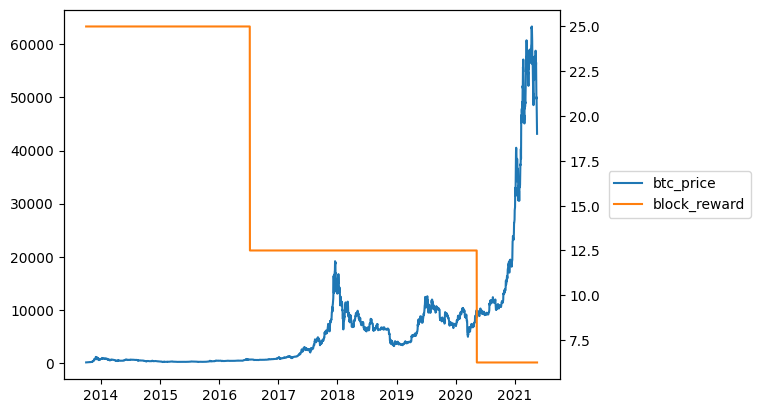

In [6]:
fig, ax1 = plt.subplots()

# Plotting the data
ln1, = ax1.plot(df["btc_price"], color="tab:blue", label="btc_price")
ax2 = ax1.twinx()
ln2, = ax2.plot(df["block_reward"], color="tab:orange", label="block_reward")

# Handling the legend
lines = [ln1, ln2]
ax1.legend(handles=lines, loc='center right', bbox_to_anchor=(1.4, 0.5))

plt.show()

In [7]:
n = len(df)

train_df = df[:int(n*0.7)].copy()
val_df = df[int(n*0.7):int(n*0.9)].copy()
test_df = df[int(n*0.9):].copy()

train_df.shape, val_df.shape, test_df. shape

((1950, 2), (558, 2), (279, 2))

In [8]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

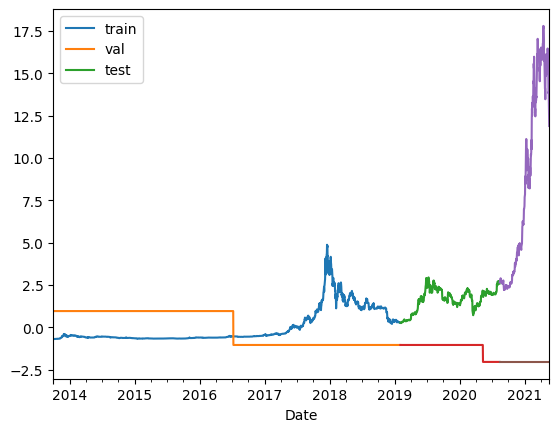

In [9]:
fig, ax = plt.subplots()
train_df.plot(ax=ax, legend=False)
val_df.plot(ax=ax, legend=False)
test_df.plot(ax=ax, legend=False)
plt.legend(["train", "val", "test"])
plt.show()

In [10]:
class WindowGenerator():
  def __init__(self,
               history_steps,
               forecast_steps,
               offset,
               train_df=train_df,
               val_df=val_df,
               test_df=test_df,
               targets=["btc_price"],
               external=[],
               ):
    assert all(train_df.columns == val_df.columns) and all(val_df.columns == test_df.columns), "columns of _df objects must be the same"
    self.train_df = train_df[targets + external]
    self.val_df = val_df[targets + external]
    self.test_df = test_df[targets + external]

    self.targets = targets
    self.targets_indices = [train_df.columns.to_list().index(lab) for lab in targets]

    assert offset >= forecast_steps, "offset must be the same or higher than forecast_steps"
    self.history_steps = history_steps
    self.forecast_steps = forecast_steps
    self.offset = offset

    self.window_size = self.history_steps + self.offset
    self.future_start = self.window_size - self.forecast_steps

    self.history_slice = slice(0, self.history_steps)
    self.future_slice = slice(self.future_start, None)

    self.T = self.history_steps
    self.N = self.train_df.shape[1]

    self.H = self.forecast_steps
    self.M = len(self.targets)

  def make_dataset(self, data, batch_size=1024):
    """
    Create sliding windows over the data.

    The window includes inputs and label, and potentially offset values,
    which are discared later (see split_window).
    """
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=batch_size,
      )
    return ds

  def split_window(self, window):
    """Extract inputs and labels from a batch of windows.

    window is a tensor of shape (batch, window, timeseries)
    for each element in the batch:
     - inputs gets the first history_steps of window
     - labels gets the last history_steps+offset-forecast_steps of window
       from the first dimension and the targets from the last dimension
    """
    inputs = window[:, self.history_slice, :]
    future = window[:, self.future_slice, :]
    labels = tf.gather(future, self.targets_indices, axis=-1)
    inputs.set_shape([None, self.T, self.N])
    labels.set_shape([None, self.H, self.M])
    return inputs, labels

  @property
  def train(self):
    return self.make_dataset(self.train_df).map(self.split_window)

  @property
  def val(self):
    return self.make_dataset(self.val_df).map(self.split_window)

  @property
  def test(self):
    return self.make_dataset(self.test_df).map(self.split_window)

  @property
  def example(self):
    result = getattr(self, '_example', None)
    if result is None:
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

In [11]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True,
)

In [12]:
val_preds = val_df.copy()
val_preds.drop(["block_reward"], axis=1, inplace=True)

test_preds = test_df.copy()
test_preds.drop(["block_reward"], axis=1, inplace=True)

In [13]:
def store_and_plot_preds(model, df, ds):
  df[model.name] = None
  mod_idx = list(df.columns).index(model.name)
  btc_idx = list(df.columns).index("btc_price")
  if isinstance(ds.element_spec[0], tf.TensorSpec):
    offset = ds.element_spec[0].shape[1]
  elif isinstance(ds.element_spec[0], dict):
    offset = ds.element_spec[0]["btc_price"].shape[1]
  df.iloc[offset:, mod_idx] = np.squeeze(model.predict(ds, verbose=0))
  df.iloc[:, [btc_idx, mod_idx]].plot()
  plt.show()

In [14]:
def smape(y_true, y_pred):
  y_pred = tf.convert_to_tensor(y_pred)
  y_true = tf.cast(y_true, y_pred.dtype)
  diff = tf.abs((y_true - y_pred)) / tf.keras.backend.maximum(tf.abs(y_true) + tf.abs(y_pred), tf.keras.backend.epsilon())
  return 200.0 * tf.keras.backend.mean(diff, axis=-1)

def mase(y_true, y_pred):
  y_pred = tf.convert_to_tensor(y_pred)
  y_true = tf.cast(y_true, y_pred.dtype)
  diff = tf.abs(y_true[1:] - y_pred[1:]) / tf.keras.backend.maximum(tf.abs(y_true[1:] - y_true[:-1]), tf.keras.backend.epsilon())
  return tf.keras.backend.mean(diff, axis=-1)

class SMAPE(tf.keras.losses.Loss):
  def call(self, y_true, y_pred):
    return smape(y_true, y_pred)

class MASE(tf.keras.losses.Loss):
  def call(self, y_true, y_pred):
      return mase(y_true, y_pred)

# Univariate, one-step ahead

In [15]:
w1 = WindowGenerator(history_steps=7, forecast_steps=1, offset=1)

## Baseline model

In [16]:
class NaiveLayer(tf.keras.layers.Layer):
  def __init__(self, targets_indices=None, forecast_steps=None, **kwargs):
    super().__init__(**kwargs)
    self.targets_indices = targets_indices
    self.forecast_steps = forecast_steps

  def call(self, inputs):
    """
    Make prediction by taking last known value from inputs.

    results is shape (batch, forecast_steps, n_targets)
    """
    results = inputs[:, -1:, :]
    results = tf.tile(results, [1, self.forecast_steps, 1])
    results = tf.gather(results, self.targets_indices, axis=-1)
    return results

inputs = tf.keras.Input(shape=(w1.T, w1.N), name="inputs")
outputs = NaiveLayer(targets_indices=w1.targets_indices, forecast_steps=w1.H, name="output")(inputs)
naive_model = tf.keras.Model(inputs, outputs, name="naive_model")

naive_model.summary()

Model: "naive_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 7, 1)]            0         
                                                                 
 output (NaiveLayer)         (None, 1, 1)              0         
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
naive_model.compile(loss="mae", metrics=["mae", "mape", smape, mase])
naive_model.evaluate(w1.val)

1/1 [==============================] - 1s 1s/step - loss: 0.0602 - mae: 0.0602 - mape: 3.7417 - smape: 3.7460 - mase: 1.0000


[0.06018109247088432,
 0.06018109247088432,
 3.7416739463806152,
 3.7459545135498047,
 1.0]

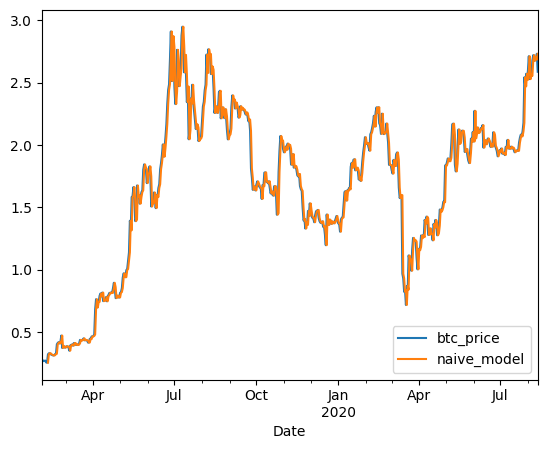

In [18]:
store_and_plot_preds(naive_model, val_preds, w1.val)

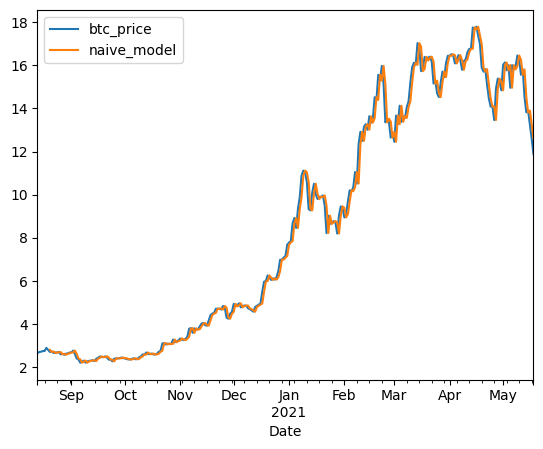

In [19]:
store_and_plot_preds(naive_model, test_preds, w1.test)

## Dense model

In [20]:
inputs = tf.keras.Input(shape=(w1.T, w1.N), name="inputs")
x = tf.keras.layers.Flatten(name="flatten")(inputs)
x = tf.keras.layers.Dense(128, activation="relu", name="dense")(x)
x = tf.keras.layers.Dense(w1.H*w1.M, name="output")(x)
outputs = tf.keras.layers.Reshape([w1.H, w1.M], name="output_reshape")(x)
dense_model = tf.keras.Model(inputs, outputs, name="dense_model")

dense_model.summary()

Model: "dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 7, 1)]            0         
                                                                 
 flatten (Flatten)           (None, 7)                 0         
                                                                 
 dense (Dense)               (None, 128)               1024      
                                                                 
 output (Dense)              (None, 1)                 129       
                                                                 
 output_reshape (Reshape)    (None, 1, 1)              0         
                                                                 
Total params: 1153 (4.50 KB)
Trainable params: 1153 (4.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
print("Input shape:", w1.example[0].shape)
print("Labels shape:", w1.example[1].shape)
print("Output shape:", dense_model(w1.example[0]).shape)

Input shape: (1024, 7, 1)
Labels shape: (1024, 1, 1)
Output shape: (1024, 1, 1)


In [22]:
dense_model.compile(loss="mae", optimizer="adam", metrics=["mae", "mape", smape, mase])

dense_model.fit(
    w1.train,
    epochs=100,
    validation_data=w1.val,
    callbacks=[early_stopping_callback]
    )

Epoch 1/100
2/2 [==============================] - 4s 528ms/step - loss: 0.5182 - mae: 0.5182 - mape: 85.5368 - smape: 149.2389 - mase: 2130.1521 - val_loss: 0.3515 - val_mae: 0.3515 - val_mape: 21.4328 - val_smape: 24.2095 - val_mase: 61.7951
Epoch 2/100
2/2 [==============================] - 0s 138ms/step - loss: 0.4408 - mae: 0.4408 - mape: 76.3253 - smape: 133.0471 - mase: 1893.3698 - val_loss: 0.2036 - val_mae: 0.2036 - val_mape: 12.5992 - val_smape: 13.4462 - val_mase: 32.0062
Epoch 3/100
2/2 [==============================] - 0s 164ms/step - loss: 0.3789 - mae: 0.3789 - mape: 68.6332 - smape: 105.9940 - mase: 1668.6907 - val_loss: 0.1271 - val_mae: 0.1271 - val_mape: 8.2208 - val_smape: 8.0900 - val_mase: 10.7903
Epoch 4/100
2/2 [==============================] - 0s 185ms/step - loss: 0.3371 - mae: 0.3371 - mape: 62.4799 - smape: 85.4315 - mase: 1454.5542 - val_loss: 0.1591 - val_mae: 0.1591 - val_mape: 10.2851 - val_smape: 9.5697 - val_mase: 24.8239
Epoch 5/100
2/2 [===========

In [23]:
dense_model.evaluate(w1.val)

1/1 [==============================] - 0s 95ms/step - loss: 0.0643 - mae: 0.0643 - mape: 4.1042 - smape: 4.0812 - mase: 4.4375


[0.06434518843889236,
 0.06434518843889236,
 4.104236125946045,
 4.081183910369873,
 4.4374613761901855]

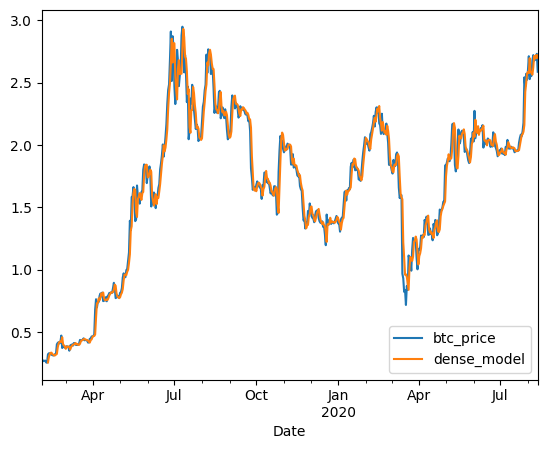

In [24]:
store_and_plot_preds(dense_model, val_preds, w1.val)

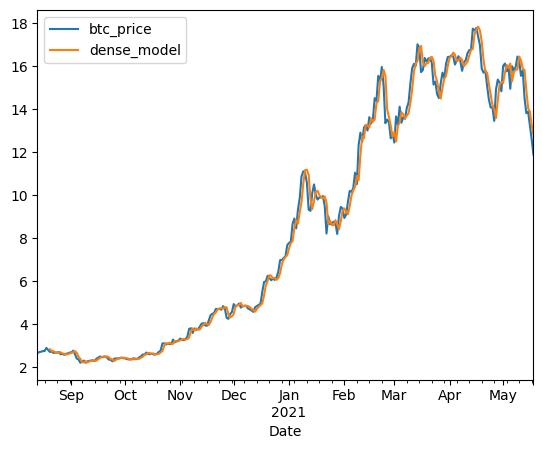

In [25]:
store_and_plot_preds(dense_model, test_preds, w1.test)

## Dense model with contemporaneous predictor

`block_reward` is known for future steps (within reason) at both training and inference time so we can use the contemporaneous effect of this feature to forecst `btc_price` alongside its lags.

In [26]:
def make_external_dataset(w, feature="block_reward", split="train"):
  if split=="train":
    df = train_df
  elif split=="val":
    df = val_df
  else:
    df = test_df
  feature_idx = list(df.columns).index("block_reward")
  ext_feature = df.iloc[w.T:, feature_idx].to_numpy().reshape(-1, 1).astype("float32")
  match_batch_size = w1.example[0].shape[0]
  ext_feature_ds = tf.data.Dataset.from_tensor_slices(ext_feature).batch(match_batch_size)
  return ext_feature_ds

def zip_datasets(x, y, external_data):
  return ({"btc_price": x, "block_reward": external_data}, y)

train_ext_ds = (
    tf.data.Dataset
    .zip((w1.train, make_external_dataset(w1, feature="block_reward", split="train")))
    .map(lambda xy, ext: zip_datasets(*xy, ext))
    )
val_ext_ds = (
    tf.data.Dataset
    .zip((w1.val, make_external_dataset(w1, feature="block_reward", split="val")))
    .map(lambda xy, ext: zip_datasets(*xy, ext))
    )
test_ext_ds = (
    tf.data.Dataset
    .zip((w1.test, make_external_dataset(w1, feature="block_reward", split="test")))
    .map(lambda xy, ext: zip_datasets(*xy, ext))
    )

In [27]:
inputs = {
    "btc_price": tf.keras.Input(shape=(w1.T, w1.N), name="btc_price"),
    "block_reward": tf.keras.Input(shape=(1), name="block_reward"),
}

x1 = tf.keras.layers.Flatten(name="flatten_1")(inputs["btc_price"])
x1 = tf.keras.layers.Dense(128, activation="relu", name="dense_1")(x1)

x2 = tf.keras.layers.Dense(128, activation="relu", name="dense_2")(inputs["block_reward"])

x = tf.keras.layers.Concatenate(name="concat")([x1, x2])

x = tf.keras.layers.Dense(w1.H*w1.M, name="output")(x)
outputs = tf.keras.layers.Reshape([w1.H, w1.M], name="output_reshape")(x)
dense_ext_model = tf.keras.Model(inputs, outputs, name="dense_ext_model")

dense_ext_model.summary()

Model: "dense_ext_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 btc_price (InputLayer)      [(None, 7, 1)]               0         []                            
                                                                                                  
 flatten_1 (Flatten)         (None, 7)                    0         ['btc_price[0][0]']           
                                                                                                  
 block_reward (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 dense_1 (Dense)             (None, 128)                  1024      ['flatten_1[0][0]']           
                                                                                    

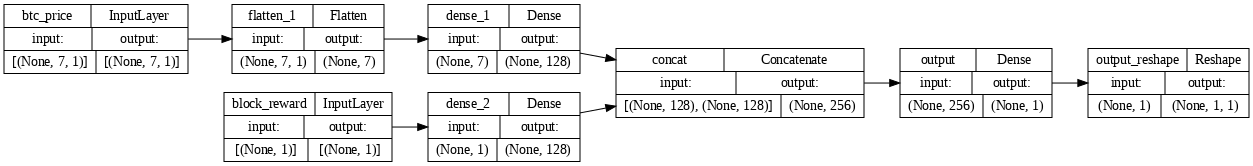

In [28]:
tf.keras.utils.plot_model(dense_ext_model, show_shapes=True, rankdir="LR", dpi=72)

In [29]:
dense_ext_model.compile(loss="mae", optimizer="adam", metrics=["mae", "mape", smape, mase])

dense_ext_model.fit(
    train_ext_ds,
    epochs=100,
    validation_data=val_ext_ds,
    callbacks=[early_stopping_callback]
    )

Epoch 1/100
2/2 [==============================] - 2s 304ms/step - loss: 0.8128 - mae: 0.8128 - mape: 106.0005 - smape: 193.4810 - mase: 2020.6052 - val_loss: 1.7419 - val_mae: 1.7419 - val_mape: 104.5965 - val_smape: 199.9938 - val_mase: 324.1517
Epoch 2/100
2/2 [==============================] - 0s 150ms/step - loss: 0.7142 - mae: 0.7142 - mape: 89.5008 - smape: 157.8761 - mase: 1690.9366 - val_loss: 1.6009 - val_mae: 1.6009 - val_mape: 95.6758 - val_smape: 183.3819 - val_mase: 297.6496
Epoch 3/100
2/2 [==============================] - 0s 156ms/step - loss: 0.6189 - mae: 0.6189 - mape: 75.1701 - smape: 121.4563 - mase: 1383.3270 - val_loss: 1.4538 - val_mae: 1.4538 - val_mape: 86.3705 - val_smape: 152.1779 - val_mase: 269.9223
Epoch 4/100
2/2 [==============================] - 0s 165ms/step - loss: 0.5239 - mae: 0.5239 - mape: 63.3681 - smape: 91.7522 - mase: 1078.4795 - val_loss: 1.3049 - val_mae: 1.3049 - val_mape: 76.9589 - val_smape: 125.4133 - val_mase: 241.7468
Epoch 5/100
2/2

In [30]:
dense_ext_model.evaluate(val_ext_ds)

1/1 [==============================] - 0s 83ms/step - loss: 0.1010 - mae: 0.1010 - mape: 7.2596 - smape: 7.0094 - mase: 11.2484


[0.10096864402294159,
 0.10096864402294159,
 7.259560585021973,
 7.009357929229736,
 11.248434066772461]

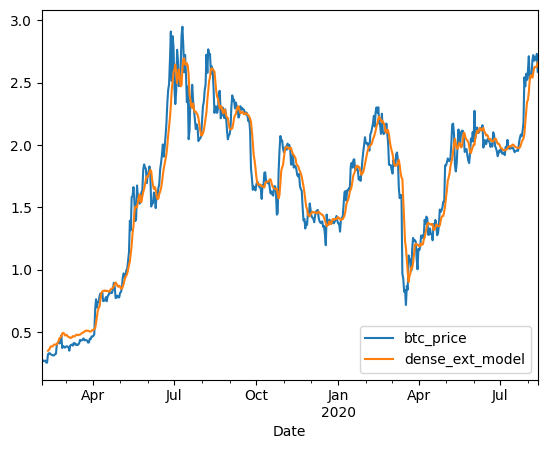

In [31]:
store_and_plot_preds(dense_ext_model, val_preds, val_ext_ds)

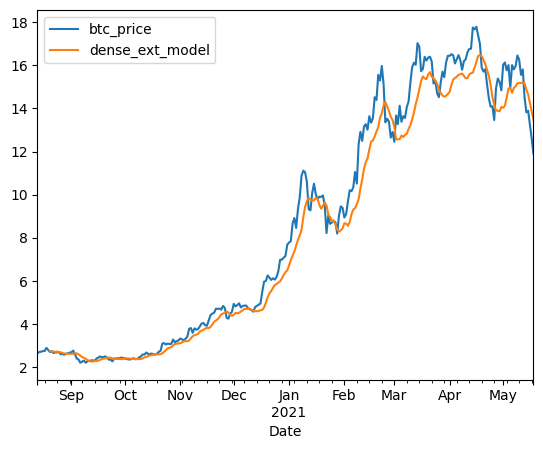

In [32]:
store_and_plot_preds(dense_ext_model, test_preds, test_ext_ds)

## Conv1D model

We can recreate `dense_model` as CNN model.

In [33]:
inputs = tf.keras.Input(shape=(w1.T, w1.N), name="inputs")
x = tf.keras.layers.Conv1D(128, kernel_size=w1.T, activation="relu", name="conv")(inputs)
outputs = tf.keras.layers.Dense(w1.M, name="output")(x)
conv_model = tf.keras.Model(inputs, outputs, name="conv_model")

conv_model.summary()

Model: "conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 7, 1)]            0         
                                                                 
 conv (Conv1D)               (None, 1, 128)            1024      
                                                                 
 output (Dense)              (None, 1, 1)              129       
                                                                 
Total params: 1153 (4.50 KB)
Trainable params: 1153 (4.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
print("Input shape:", w1.example[0].shape)
print("Labels shape:", w1.example[1].shape)
print("Output shape:", conv_model(w1.example[0]).shape)

Input shape: (1024, 7, 1)
Labels shape: (1024, 1, 1)
Output shape: (1024, 1, 1)


Let's try out a different architecture

In [35]:
w30 = WindowGenerator(history_steps=30, forecast_steps=1, offset=1)

In [36]:
inputs = tf.keras.Input(shape=(w30.T, w30.N), name="inputs")
x = tf.keras.layers.Conv1D(128, kernel_size=3, padding="causal", activation="relu")(inputs)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(w30.H*w30.M, name="output")(x)
outputs = tf.keras.layers.Reshape([w30.H, w30.M], name="output_reshape")(x)
conv_model = tf.keras.Model(inputs, outputs, name="conv_model")

conv_model.summary()

Model: "conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 30, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 30, 128)           512       
                                                                 
 dense (Dense)               (None, 30, 64)            8256      
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 output (Dense)              (None, 1)                 1921      
                                                                 
 output_reshape (Reshape)    (None, 1, 1)              0         
                                                                 
Total params: 10689 (41.75 KB)
Trainable params: 10689 (

In [37]:
print("Input shape:", w30.example[0].shape)
print("Labels shape:", w30.example[1].shape)
print("Output shape:", conv_model(w30.example[0]).shape)

Input shape: (1024, 30, 1)
Labels shape: (1024, 1, 1)
Output shape: (1024, 1, 1)


In [38]:
conv_model.compile(loss="mae", optimizer="adam", metrics=["mae", "mape", smape, mase])

conv_model.fit(
    w30.train,
    epochs=100,
    validation_data=w30.val,
    callbacks=[early_stopping_callback]
    )

Epoch 1/100
2/2 [==============================] - 5s 610ms/step - loss: 0.8162 - mae: 0.8162 - mape: 105.3174 - smape: 195.3801 - mase: 2169.3740 - val_loss: 1.6530 - val_mae: 1.6530 - val_mape: 95.6870 - val_smape: 183.5232 - val_mase: 306.6468
Epoch 2/100
2/2 [==============================] - 0s 208ms/step - loss: 0.6813 - mae: 0.6813 - mape: 87.6895 - smape: 147.8910 - mase: 1684.3291 - val_loss: 1.4871 - val_mae: 1.4871 - val_mape: 85.9186 - val_smape: 150.9214 - val_mase: 274.2973
Epoch 3/100
2/2 [==============================] - 0s 213ms/step - loss: 0.5600 - mae: 0.5600 - mape: 73.1308 - smape: 104.1319 - mase: 1274.4668 - val_loss: 1.3115 - val_mae: 1.3115 - val_mape: 75.6603 - val_smape: 122.3185 - val_mase: 239.9457
Epoch 4/100
2/2 [==============================] - 0s 141ms/step - loss: 0.4386 - mae: 0.4386 - mape: 58.9746 - smape: 71.0392 - mase: 861.2150 - val_loss: 1.1343 - val_mae: 1.1343 - val_mape: 65.2890 - val_smape: 97.8738 - val_mase: 205.3601
Epoch 5/100
2/2 [=

In [39]:
conv_model.evaluate(w30.val)

1/1 [==============================] - 0s 88ms/step - loss: 0.2322 - mae: 0.2322 - mape: 14.6478 - smape: 14.0535 - mase: 29.5679


[0.23215949535369873,
 0.23215949535369873,
 14.647825241088867,
 14.053520202636719,
 29.567888259887695]

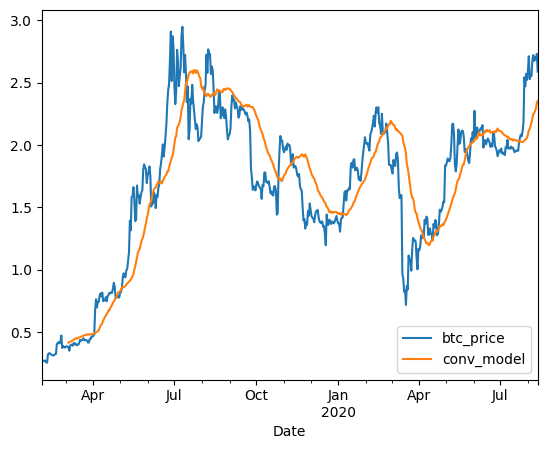

In [40]:
store_and_plot_preds(conv_model, val_preds, w30.val)

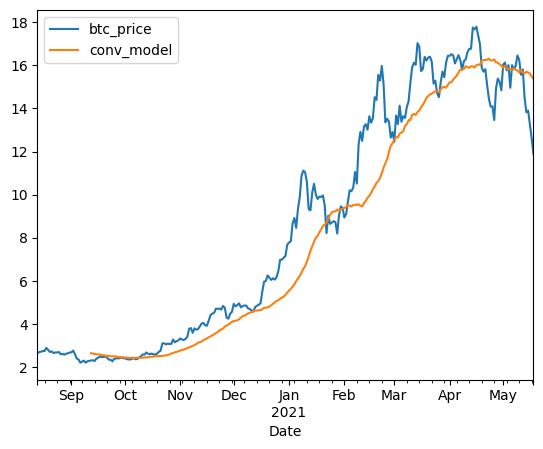

In [41]:
store_and_plot_preds(conv_model, test_preds, w30.test)

## RNN model

In [42]:
inputs = tf.keras.Input(shape=(w30.T, w30.N), name="inputs")
x = tf.keras.layers.LSTM(128, activation="relu", name="lstm")(inputs)
x = tf.keras.layers.Dense(w30.H*w30.M, name="output")(x)
outputs = tf.keras.layers.Reshape([w30.H, w30.M], name="output_reshape")(x)
rnn_model = tf.keras.Model(inputs, outputs, name="rnn_model")

rnn_model.summary()

Model: "rnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 30, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 output (Dense)              (None, 1)                 129       
                                                                 
 output_reshape (Reshape)    (None, 1, 1)              0         
                                                                 
Total params: 66689 (260.50 KB)
Trainable params: 66689 (260.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
print("Input shape:", w30.example[0].shape)
print("Labels shape:", w30.example[1].shape)
print("Output shape:", rnn_model(w30.example[0]).shape)

Input shape: (1024, 30, 1)
Labels shape: (1024, 1, 1)
Output shape: (1024, 1, 1)


In [44]:
rnn_model.compile(loss="mae", optimizer="adam", metrics=["mae", "mape", smape, mase])

rnn_model.fit(
    w30.train,
    epochs=100,
    validation_data=w30.val,
    callbacks=[early_stopping_callback]
    )

Epoch 1/100
2/2 [==============================] - 2s 419ms/step - loss: 0.7365 - mae: 0.7365 - mape: 92.5502 - smape: 171.0761 - mase: 1823.6167 - val_loss: 1.6551 - val_mae: 1.6551 - val_mape: 95.7583 - val_smape: 183.7343 - val_mase: 307.2777
Epoch 2/100
2/2 [==============================] - 0s 153ms/step - loss: 0.6800 - mae: 0.6800 - mape: 84.9250 - smape: 145.5555 - mase: 1637.0107 - val_loss: 1.5726 - val_mae: 1.5726 - val_mape: 90.9373 - val_smape: 166.8035 - val_mase: 291.8598
Epoch 3/100
2/2 [==============================] - 0s 158ms/step - loss: 0.6215 - mae: 0.6215 - mape: 77.2758 - smape: 122.9221 - mase: 1444.0045 - val_loss: 1.4846 - val_mae: 1.4846 - val_mape: 85.8101 - val_smape: 150.3835 - val_mase: 275.4359
Epoch 4/100
2/2 [==============================] - 0s 172ms/step - loss: 0.5560 - mae: 0.5560 - mape: 68.7211 - smape: 101.0990 - mase: 1220.9578 - val_loss: 1.3897 - val_mae: 1.3897 - val_mape: 80.2993 - val_smape: 134.3195 - val_mase: 257.7437
Epoch 5/100
2/2 

In [45]:
rnn_model.evaluate(w30.val)

1/1 [==============================] - 0s 143ms/step - loss: 0.0876 - mae: 0.0876 - mape: 5.4157 - smape: 5.3963 - mase: 10.5298


[0.08759307116270065,
 0.08759307116270065,
 5.415741920471191,
 5.396327495574951,
 10.529837608337402]

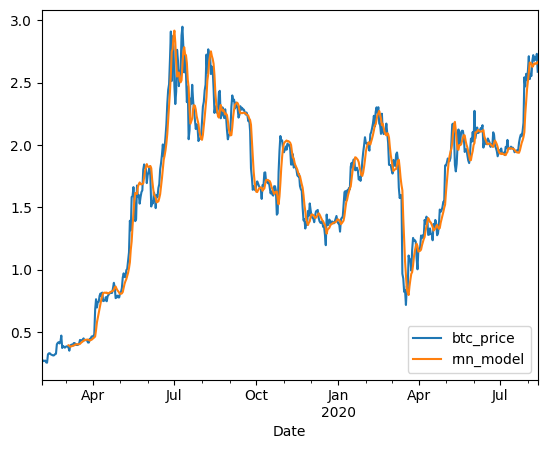

In [46]:
store_and_plot_preds(rnn_model, val_preds, w30.val)

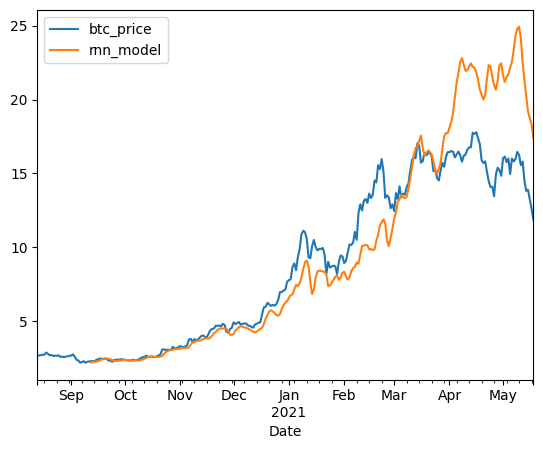

In [47]:
store_and_plot_preds(rnn_model, test_preds, w30.test)

## N-BEATS model

In [48]:
LH = 10
LOOKBACK = 7
EPOCHS = 5000
LOSSES = [tf.keras.losses.MeanAbsolutePercentageError(), SMAPE(), MASE()]
BATCH = 1024
STACKS = 30
BLOCKS = 1
BLOCK_LAYERS = 4
WIDTH = 512
H = 1

In [49]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               width=WIDTH,
               layers=BLOCK_LAYERS,
               forecast_steps=H,
               lookback_coefficient=LOOKBACK,
               name="nbeats_block",
               **kwargs):
    super(NBeatsBlock, self).__init__(name=name, **kwargs)
    self.width = width
    self.num_layers = layers
    self.forecast_steps = forecast_steps
    self.backcast_steps = lookback_coefficient*self.forecast_steps
    self.denses = [tf.keras.layers.Dense(self.width, activation="relu", name=f"block_fc_{i+1}") for i in range(self.num_layers)]
    self.out = tf.keras.layers.Dense(self.backcast_steps+self.forecast_steps, name=f"block_out")

  def call(self, inputs):
    x = inputs  # (None, history_length)
    for dense in self.denses:
      x = dense(x)
    output = self.out(x) # (None, backcast_steps+forecast_steps)
    block_backcast = output[:, :self.backcast_steps]
    block_forecast = output[:, -self.forecast_steps:]
    return block_backcast, block_forecast  # (None, backcast_steps), (None, forecast_steps)

class NBeatsStack(tf.keras.layers.Layer):
  def __init__(self,
               blocks=BLOCKS,
               name="nbeats_stack",
               **kwargs):
    super(NBeatsStack, self).__init__(name=name, **kwargs)
    self.blocks = blocks
    self.nbeats_blocks = [NBeatsBlock(name=f"fc_block_{i+1}") for i in range(self.blocks)]
    self.backcast_steps = self.nbeats_blocks[0].backcast_steps
    self.residuals = [tf.keras.layers.Subtract(name=f"block_{i+1}_res") for i in range(self.blocks)]

  def call(self, inputs):
    res = inputs[:, -self.backcast_steps:]  # (None, backcast_steps)
    block_forecasts = []
    for i in range(self.blocks):
      b, f = self.nbeats_blocks[i](res)
      block_forecasts.append(f)
      res = self.residuals[i]([res, b])
    stack_residual = res
    stack_forecast = tf.keras.layers.Add(name="add_forecasts")(block_forecasts)
    return stack_residual, stack_forecast  # (None, backcast_steps), (None, forecast_steps)

class NBeatsModel(tf.keras.Model):
  def __init__(self,
               stacks=STACKS,
               name="nbeats_model",
               **kwargs):
    super(NBeatsModel, self).__init__(name=name, **kwargs)
    self.stacks = stacks
    self.flatten = tf.keras.layers.Flatten(name="flatten")
    self.nbeats_stacks = [NBeatsStack(name=f"fc_stack_{i+1}") for i in range(self.stacks)]
    self.forecast_steps = self.nbeats_stacks[0].nbeats_blocks[0].forecast_steps
    self.reshape = tf.keras.layers.Reshape([self.forecast_steps, 1])

  def call(self, inputs):
    x = inputs  # (None, history_length, 1)
    x = self.flatten(x)  # (None, history_length)
    stack_forecasts = []
    for i in range(self.stacks):
      x, f = self.nbeats_stacks[i](x)
      stack_forecasts.append(f)
    model_forecast = tf.keras.layers.Add(name="add_forecasts")(stack_forecasts)
    model_forecast = self.reshape(model_forecast)
    return model_forecast  # (None, forecast_steps, 1)

  def model(self):
    x = tf.keras.Input(shape=(30, 1), name="inputs")
    return tf.keras.Model(inputs=[x], outputs=self.call(x), name=self.name)

In [50]:
nbeats_model = NBeatsModel()
nbeats_model.model().summary()

Model: "nbeats_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 30, 1)]              0         []                            
                                                                                                  
 flatten (Flatten)           (None, 30)                   0         ['inputs[0][0]']              
                                                                                                  
 fc_stack_1 (NBeatsStack)    ((None, 7),                  796168    ['flatten[0][0]']             
                              (None, 1))                                                          
                                                                                                  
 fc_stack_2 (NBeatsStack)    ((None, 7),                  796168    ['fc_stack_1[0][0]'

In [51]:
print("Input shape:", w1.example[0].shape)
print("Labels shape:", w1.example[1].shape)
print("Output shape:", nbeats_model(w1.example[0]).shape)

Input shape: (1024, 7, 1)
Labels shape: (1024, 1, 1)
Output shape: (1024, 1, 1)


In [52]:
nbeats_model.compile(loss=LOSSES, optimizer="adam", metrics=["mae", "mape", smape, mase])

nbeats_model.fit(
    w1.train,
    epochs=EPOCHS,
    validation_data=w1.val,
    callbacks=[early_stopping_callback]
    )

Epoch 1/5000
2/2 [==============================] - 51s 2s/step - loss: 673.7489 - mae: 4.2009 - mape: 673.7489 - smape: 195.9174 - mase: 6602.0806 - val_loss: 107.1998 - val_mae: 1.7241 - val_mape: 107.1998 - val_smape: 197.2468 - val_mase: 325.9332
Epoch 2/5000
2/2 [==============================] - 1s 342ms/step - loss: 368.0647 - mae: 1.7767 - mape: 368.0647 - smape: 128.6107 - mase: 5954.2134 - val_loss: 45.4584 - val_mae: 0.8220 - val_mape: 45.4584 - val_smape: 60.4645 - val_mase: 151.3626
Epoch 3/5000
2/2 [==============================] - 0s 157ms/step - loss: 66.1825 - mae: 0.5279 - mape: 66.1825 - smape: 89.5155 - mase: 940.0349 - val_loss: 60.9204 - val_mae: 0.8676 - val_mape: 60.9204 - val_smape: 44.4252 - val_mase: 171.6024
Epoch 4/5000
2/2 [==============================] - 0s 162ms/step - loss: 105.3254 - mae: 0.3943 - mape: 105.3254 - smape: 60.0922 - mase: 909.4399 - val_loss: 99.9920 - val_mae: 1.6247 - val_mape: 99.9920 - val_smape: 188.7250 - val_mase: 306.3114
Epoc

In [53]:
nbeats_model.evaluate(w1.val)

1/1 [==============================] - 0s 101ms/step - loss: 4.2507 - mae: 0.0669 - mape: 4.2507 - smape: 4.2030 - mase: 4.1166


[4.250712871551514,
 0.06689576804637909,
 4.250712871551514,
 4.202976226806641,
 4.116586685180664]

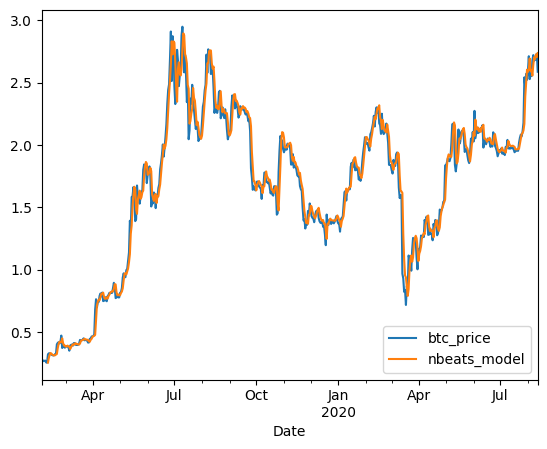

In [54]:
store_and_plot_preds(nbeats_model, val_preds, w1.val)

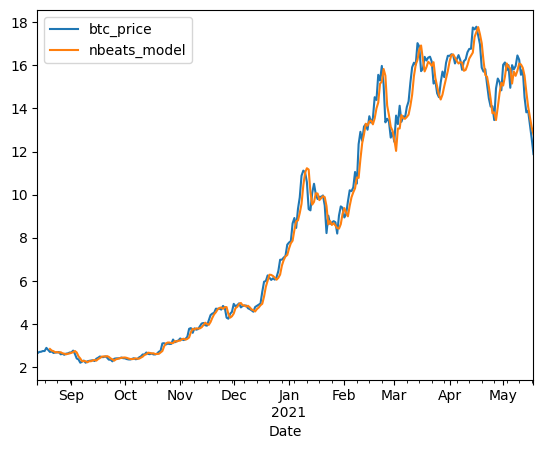

In [55]:
store_and_plot_preds(nbeats_model, test_preds, w1.test)